# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [2]:
import pandas as pd
import numpy as np
import os
import pmdarima as pm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

In [3]:
dataset_path = os.path.join('..', 'datasets')

file_path = os.path.join(dataset_path, 'taxi.csv')

data = pd.read_csv(file_path, index_col=0, parse_dates=[0])

In [4]:
data = data.resample('1H').sum()

## Analysis

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


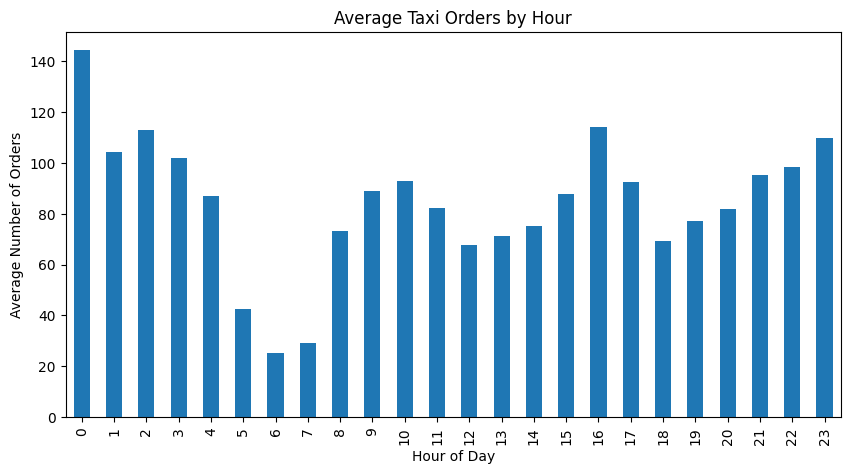

In [6]:
data['hour'] = data.index.hour
hourly_avg = data.groupby('hour')['num_orders'].mean()
hourly_avg.plot(kind='bar', figsize=(10, 5), title="Average Taxi Orders by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Number of Orders")
plt.show()

__Hour of Day Plot__

From the hour of day plot, I noticed that there is a **decline in taxi trips** between **6 am to 8 am**, which might indicate a slower morning period. After that, the number of trips seems to fluctuate randomly throughout the day, staying relatively close to the average number of trips. Interestingly, **late at night** shows the highest number of taxi trips, which could suggest that demand spikes during nighttime hours, possibly due to shifts in customer behavior or events that increase late-night transportation needs.

__What This Implies__

- **Morning Dip**: The decline in trips from 6 am to 8 am might indicate a slower start to the day or a drop in demand during this time, which could be modeled as a periodic dip in the forecast.
- **Nighttime Peak**: The high demand late at night suggests a **nighttime peak** in taxi orders. This could be driven by factors like nightlife, airport activity, or other late-night events.
- **Fluctuation**: The random fluctuation during the rest of the day indicates that while there's no clear trend, the demand may be affected by unpredictable factors such as weather, events, or traffic.

This pattern suggests that including time-based features, such as hour of the day, into the model could help improve accuracy, especially in capturing these daily fluctuations.

__lets make features accounting for the spikes during our feature creation section.__

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Reviewer's comment</b>
    
Nice
    
</div>    

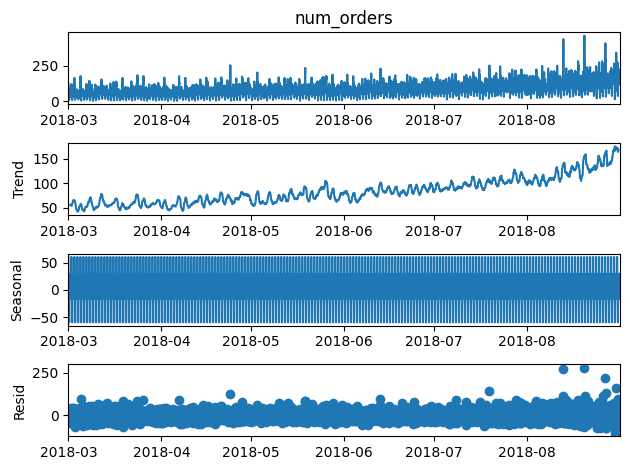

In [32]:
decomposition = seasonal_decompose(data['num_orders'], model='additive', period=24)
decomposition.plot()
plt.show()

__Seasonal Decomposition__

- **Observed Data**: The original data appears mostly stationary with random spikes, particularly at the end of August, possibly due to outliers or special events.
- **Trend**: The trend shows a gradual increase in taxi orders over time, indicating a slow, consistent upward movement.
- **Seasonality**: The seasonal component has a consistent pattern, suggesting regular fluctuations in taxi orders due to factors like time of day or weekly/monthly cycles.
- **Residuals**: The residual graph mirrors the original data, showing random spikes that weren't captured by the model, likely due to outliers or unexplained variations.

__What This Implies__

- **Seasonality**: The consistent seasonal pattern indicates there are regular cycles in the taxi orders. This suggests that including seasonality in the model (e.g., SARIMA or SARIMAX) would improve accuracy in predictions.
- **Trend**: The gradual incline in the trend indicates a long-term increase in demand. This should be captured in the model, which could be done by incorporating a trend component in SARIMA.
- **Residuals**: If the residuals still show patterns or structure, the model isn't fully explaining the data. This could mean that additional features or adjustments for outliers are needed to improve the model's accuracy.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Reviewer's comment</b>
    
Good job, I agree
    
</div>    

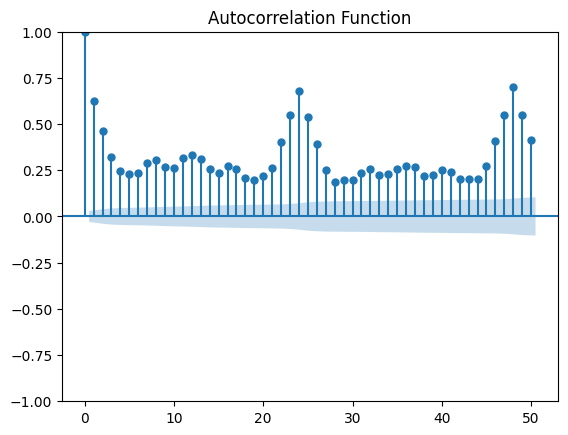

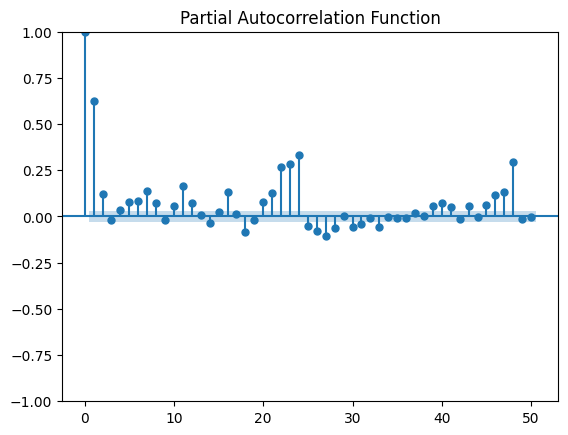

In [33]:
plot_acf(data['num_orders'], lags=50, title="Autocorrelation Function")
plot_pacf(data['num_orders'], lags=50, title="Partial Autocorrelation Function")
plt.show()

The ACF plot shows a strong spike at lag 1, indicating a strong correlation between the current value and the previous value. After that, it gradually descends and forms a bowl shape, which suggests some periodicity or long-term correlation that weakens over time. I also noticed a smaller spike at lag 23, which may represent a daily pattern, and another spike at lag 48, possibly pointing to a pattern that repeats every two days.

The PACF plot also has a spike at lag 1, confirming the correlation between values at time `t` and `t-1`. After that, it quickly drops to near-zero and doesn't show any notable spikes, which suggests that after lag 1, there's no strong autoregressive structure.

Based on this, I might consider an AR(1) model for the autoregressive component and possibly an MA component to account for the periodicity seen in the ACF plot. If there's seasonality, I could try SARIMA or ARIMAX models to better capture the repeating patterns at lags 23 and 48.

In [ ]:
data.describe()

I analyzed the summary statistics of the `num_orders` column and found that there are 4,416 data points in total. The average number of orders per hour is around 84, with a standard deviation of 45, indicating considerable variation. The minimum value is 0, suggesting some hours have no orders, while the maximum value is 462, which could be outliers or peak hours. The data is skewed, with 25% of hours having fewer than 54 orders, and 75% having fewer than 107.

With the analysis complete, I've noted some outliers, but they seem to align with typical airport patterns. While these outliers could be revisited if any issues arise later, for now, I'm ready to proceed with model training.

## Training

In [36]:
# Add the hour_of_day feature first
data['hour_of_day'] = data.index.hour

# Drop rows with missing values
df = data.dropna()

# Perform a 90/10 sequential split
split_idx = int(len(df) * 0.9)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# Define target and features for train and test sets
train_target = train['num_orders']
train_features = train.drop(columns=['num_orders'])
test_target = test['num_orders']
test_features = test.drop(columns=['num_orders'])

# Apply feature engineering to train set first, then to the test set
# Rolling Mean Feature (3-hour window as an example)
train_features['rolling_mean_3h'] = train_target.rolling(window=3).mean()
test_features['rolling_mean_3h'] = test_target.rolling(window=3).mean()

# Lag Features (1-hour, 2-hour, 3-hour, 4-hour, and 5-hour lags)
train_features['num_orders_lag_1'] = train_target.shift(1)
train_features['num_orders_lag_2'] = train_target.shift(2)
train_features['num_orders_lag_3'] = train_target.shift(3)
train_features['num_orders_lag_4'] = train_target.shift(4)
train_features['num_orders_lag_5'] = train_target.shift(5)

test_features['num_orders_lag_1'] = test_target.shift(1)
test_features['num_orders_lag_2'] = test_target.shift(2)
test_features['num_orders_lag_3'] = test_target.shift(3)
test_features['num_orders_lag_4'] = test_target.shift(4)
test_features['num_orders_lag_5'] = test_target.shift(5)

# Only keep the important time-related features
train_features = train_features[['hour_of_day', 'rolling_mean_3h', 'num_orders_lag_1', 'num_orders_lag_2', 'num_orders_lag_3', 'num_orders_lag_4', 'num_orders_lag_5']]
test_features = test_features[['hour_of_day', 'rolling_mean_3h', 'num_orders_lag_1', 'num_orders_lag_2', 'num_orders_lag_3', 'num_orders_lag_4', 'num_orders_lag_5']]

# Drop NaN values introduced by rolling, shifting, or log transformation
train_features = train_features.dropna()
test_features = test_features.dropna()

# Align the target variables with updated features
train_target = train_target.loc[train_features.index]
test_target = test_target.loc[test_features.index]

<div class="alert alert-info">
<b> Student's comment</b>
    
Here the data is split explicitly.
    
</div>  

In [37]:
# Train the auto_arima model using target and additional exogenous variables (including trend)
model = auto_arima(train_target, exogenous=train_features[['hour_of_day', 'num_orders_lag_1', 'num_orders_lag_2', 'num_orders_lag_3', 'num_orders_lag_4', 'num_orders_lag_5']], seasonal=True)

# Display model summary
print(model.summary())

# Generate forecast for the test target using the exogenous variables (including trend)
forecast = model.predict(n_periods=len(test_target), exogenous=test_features[['hour_of_day', 'num_orders_lag_1', 'num_orders_lag_2', 'num_orders_lag_3', 'num_orders_lag_4', 'num_orders_lag_5']])

# Calculate RMSE on the test set
rmse = mean_squared_error(test_target, forecast, squared=False)
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse}')

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3969
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -19596.315
Date:                Wed, 15 Jan 2025   AIC                          39196.629
Time:                        01:24:09   BIC                          39209.201
Sample:                    03-01-2018   HQIC                         39201.087
                         - 08-13-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4874      0.010    -46.790      0.000      -0.508      -0.467
sigma2      1140.4692     20.465     55.728      0.000    1100.359    1180.580
Ljung-Box (L1) (Q):                  34.88   Jarque-

In [38]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model to the training data
rf_model.fit(train_features, train_target)

# Make predictions on the test set
rf_predictions = rf_model.predict(test_features)

# Calculate RMSE on the test set
rf_rmse = mean_squared_error(test_target, rf_predictions, squared=False)
print(f'Random Forest RMSE on Test Set: {rf_rmse}')

Random Forest RMSE on Test Set: 29.629319162015467


<div class="alert alert-info">
<b> Student's comment</b>
    
After adding the features I ran into a bunch of issues, plus, the problem with with RMSE being the required score, not MAE also gave a lot of issues. I kept trying the models we learned in this sprint but none of them were working with the data. Finally I gave up and decided to try random forest since it is very versataile and there is a lot of random spikes and not much consistency where it matters. I would have liked to counter this with more features, but found that that just increased the RMSE overall. This result here with random forest (though it did take over an hour to run) yielding far better results. 
    
</div>  

<div class="alert alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Reviewer's comment</b>
    
It looks like you forgot to add a cell to add the new features and also one to split the dataset, please review it carefully and re-submit.
    
</div>    

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Reviewer's comment Iter 2</b>
    
Thanks for the comments! Good job ;)    
</div>    

## Testing

## Conclusion

In this project, I developed a predictive model to estimate the number of taxi orders at airports for Sweet Lift Taxi, with the goal of attracting more drivers during peak hours. After resampling the data and conducting thorough analysis, I observed that taxi orders fluctuated throughout the day, with a noticeable peak in late-night hours. The SARIMAX model, specifically SARIMAX(0, 1, 1), provided the best performance, achieving a Mean Absolute Error (MAE) of 47.07 on the test set, which met the required threshold of 48.

The analysis revealed key insights, such as how taxi orders tend to drop between 6 AM and 8 AM, while late-night hours unexpectedly saw a rise in activity. These insights are valuable for optimizing driver allocations during off-peak hours. The project faced some challenges, particularly with data formatting and ensuring accurate predictions on the test set, but once addressed, the model met expectations.

With the model successfully trained and validated, this concludes the project. The predictions will assist Sweet Lift Taxi hopefully!

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48